In [ ]:
from sklearn import datasets
import seaborn as sns
from sklearn import linear_model
from sklearn import manifold
import random
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from sklearn.neural_network import MLPRegressor

from dbmap import CLF
from dbmap import DBMap
import json

from lamp import ILAMP

n_samples = 100
COLORS = ["#377eb8", "#ff7f00", '#4daf4a', '#00CED1', '#008000', '#D2691E', '#A020F0', '#FF1493', '#8B0000', '#FFD700']
#cores = azul escuro, laranja claro, verde claro, ciano, verde escuro, laranja escuro, roxo, rosa, vermelho, amarelo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
names = ["Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [ ]:
classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

#Funções

In [ ]:
def Reduzirexemplos(digit, X_train, y_train, X_test, y_test):

  ind_class = np.where(y_train == digit)
  np.random.shuffle(ind_class[0])
  inds_to_exclude = ind_class[0][:int(np.round(len(ind_class[0])*0.90))]

  y_train = np.delete(y_train, inds_to_exclude)
  X_train = np.delete(X_train, inds_to_exclude, axis = 0)

  print("X_train shape", X_train.shape)
  print("y_train shape", y_train.shape)
  print("X_test shape", X_test.shape)
  print("y_test shape", y_test.shape)

  return (X_train, y_train), (X_test, y_test)

In [ ]:
def Reduzirclasses(class1, class2, X_train, y_train, X_test, y_test):
  for digit in range(0,10):
    if (digit != class1) and (digit != class2):
      ind_class = np.where(y_train == digit)
      y_train = np.delete(y_train, ind_class)
      X_train = np.delete(X_train, ind_class, axis = 0)

      ind_class_test = np.where(y_test == digit)
      y_test = np.delete(y_test, ind_class_test)
      X_test = np.delete(X_test, ind_class_test, axis = 0)

  print("X_train shape", X_train.shape)
  print("y_train shape", y_train.shape)
  print("X_test shape", X_test.shape)
  print("y_test shape", y_test.shape)

  return (X_train, y_train), (X_test, y_test) 

In [ ]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 10
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [ ]:
def GenerateDatanoise(X_train_idx):
  # Prepare data-augmenting data generator
  from keras.preprocessing.image import ImageDataGenerator
  datagen = ImageDataGenerator(
          rescale=1./255,
          rotation_range=20,
          width_shift_range=0.1,
          height_shift_range=0.1,
          zoom_range=0.1,
          preprocessing_function=add_noise,
      )
  # Load a single image as our example
  from keras.preprocessing import image
  img = X_train_idx

  # Generate distorted images
  images = [img]
  img_arr = image.img_to_array(img)
  img_arr = img_arr.reshape((1,) + img_arr.shape)
  for batch in datagen.flow(img_arr, batch_size=1):
      images.append( image.array_to_img(batch[0]) )
      if len(images) >= 100:
          break
  return images

In [ ]:
def Aumentarexemplos(X_train, y_train, X_test, y_test):
  
  #idxmais=[652, 1758, 1281, 1355, 365] #MAIS DISCRIMINANTES
  idxmais = [54, 1957, 674, 668, 747] #MAIS DIFICEIS
  #idxmais=[1577, 409, 1079, 1983, 35] #MAIORES CHUTES

  for j in idxmais:
       
    datanoise = GenerateDatanoise(X_test[j])
    for i in range(0, len(datanoise)):
      X_train = np.append(X_train, [np.array(datanoise[i])], axis=0)
      y_train = np.append(y_train, y_test[j])

  print("X_train shape", X_train.shape)
  print("y_train shape", y_train.shape)
  print("X_test shape", X_test.shape)
  print("y_test shape", y_test.shape)

  return (X_train, y_train), (X_test, y_test)

# Exemplos próximos

In [ ]:
(X_train, y_train), (X_test, y_test)  = fashion_mnist.load_data()
class1 = 2
class2 = 4
digit = 0

#(X_train, y_train), (X_test, y_test)  = Reduzirexemplos(digit, X_train, y_train, X_test, y_test)

(X_train, y_train), (X_test, y_test)   = Reduzirclasses(class1, class2, X_train, y_train, X_test, y_test)

(train_images, train_labels), (test_images, test_labels)  = Aumentarexemplos(X_train, y_train, X_test, y_test)

#train_images = train_images.reshape(60000,28,28,1)
#test_images  = test_images.reshape(10000,28,28,1)

n_X_train = len(X_train)
n_X_test = len(X_test)

X_train = X_train.reshape(n_X_train, 784)
X_test = X_test.reshape(n_X_test, 784)

X_train shape (12000, 28, 28)
y_train shape (12000,)
X_test shape (2000, 28, 28)
y_test shape (2000,)
X_train shape (12500, 28, 28)
y_train shape (12500,)
X_test shape (2000, 28, 28)
y_test shape (2000,)


In [ ]:
# FIXME: normalize train data, apply normalization to test data
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
for name, clf in zip(names, classifiers):
  clf.fit(X_train, y_train) 
  score = clf.score(X_test, y_test)
  print("Score ", name, ": ", score)

Score  Decision Tree :  0.8095
Score  Random Forest :  0.744
Score  Neural Net :  0.884
Score  AdaBoost :  0.84
Score  Naive Bayes :  0.658


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Score  QDA :  0.632


In [ ]:
tsne = manifold.TSNE(perplexity=10)
X_proj = tsne.fit_transform(X_train)
proj_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_proj = proj_scaler.fit_transform(X_proj)


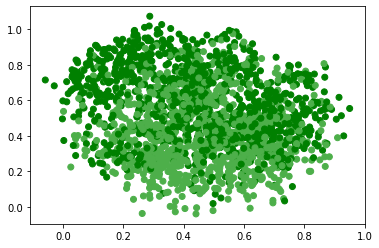

In [ ]:
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, X_proj)
pred = regr.predict(X_test)
colors = [COLORS[v] for v in y_test]
plt.scatter(pred[:, 0], pred[:, 1], color=colors)

In [ ]:
clf = CLF(classifiers[0], clf_type="sklearn")
basedir = '/tmp/syn_test/'

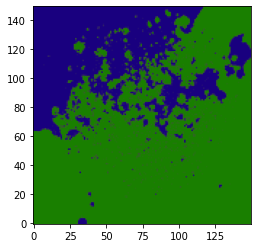

In [ ]:
R = 150
N = 10

dbmap = DBMap(R, N)
dbmap.fit(clf, X_test, pred)

plt.imshow(hsv_to_rgb(dbmap.hsv_map), origin='lower')

# TRI


In [ ]:
pred1 = classifiers[0].predict(X_test)
pred2 = classifiers[1].predict(X_test)
pred3 = classifiers[2].predict(X_test)
pred4 = classifiers[3].predict(X_test)
pred5 = classifiers[4].predict(X_test)
pred6 = classifiers[5].predict(X_test)

predictions = [pred1, pred2, pred3, pred4, pred5, pred6]

In [ ]:
idx = [725, 1683, 1424, 1708, 1334, 1930, 122, 1776, 1446, 1707, 415, 54, 1737, 445, 278, 885, 1579, 1780, 1063, 674, 1544, 1727, 1862, 745, 1565, 625, 349, 366, 479, 1439, 1154, 1794, 855, 630, 1413, 1427, 1281, 323, 1060, 1920, 1554, 901, 1891, 1169, 487, 1019, 1445, 1151, 452, 917, 528, 1758, 722, 1848, 539, 1403, 1101, 306, 1346, 1201, 1071, 1186, 1469, 1261, 384, 347, 652, 1716, 1000, 1495, 558, 10, 762, 667, 1487, 1481, 886, 1606, 1752, 453, 1310, 1393, 1351, 1476, 875, 1355, 56, 1950, 365, 1454, 1957, 1945, 1142, 657, 1566, 663, 668, 1893, 1237, 636, 1079, 899, 1985, 39, 1724, 533, 936, 1983, 260, 1250, 1400, 1248, 1688, 593, 483, 591, 1798, 1881, 1179, 971, 1466, 1200, 1618, 1593, 345, 397, 631, 906, 1592, 1236, 1022, 1027, 575, 847, 1615, 190, 817, 423, 1141, 1116, 687, 570, 1189, 1190, 500, 336, 371, 22, 1590, 545, 499, 140, 627, 916, 1388, 85, 1329, 523, 1373, 1150, 460, 289, 502, 135, 1754, 1651, 1024, 276, 1354, 793, 1702, 1885, 1067, 1382, 409, 717, 585, 1028, 35, 1068, 1490, 1110, 951, 372, 938, 747, 1807, 1280, 1091, 253, 1499, 1399, 1489, 1340, 442, 800, 1577, 1946, 1879, 1402]


In [ ]:
resultado = []
for predi in predictions:
  labels = []
  preds = []
  for i in idx: 
    labels.append(y_test[i])
    preds.append(predi[i])
  res = []
  for i, j in zip(labels, preds):
    if(i == j):
      z = 1
    else:
      z = 0
    res.append(z)
  resultado.append(res)
print(resultado[4])

[0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
colunas = []
nitens = 200 
for i in range(1, nitens+1):
  colunas.append("Item."+ str(i))
print(colunas)

['Item.1', 'Item.2', 'Item.3', 'Item.4', 'Item.5', 'Item.6', 'Item.7', 'Item.8', 'Item.9', 'Item.10', 'Item.11', 'Item.12', 'Item.13', 'Item.14', 'Item.15', 'Item.16', 'Item.17', 'Item.18', 'Item.19', 'Item.20', 'Item.21', 'Item.22', 'Item.23', 'Item.24', 'Item.25', 'Item.26', 'Item.27', 'Item.28', 'Item.29', 'Item.30', 'Item.31', 'Item.32', 'Item.33', 'Item.34', 'Item.35', 'Item.36', 'Item.37', 'Item.38', 'Item.39', 'Item.40', 'Item.41', 'Item.42', 'Item.43', 'Item.44', 'Item.45', 'Item.46', 'Item.47', 'Item.48', 'Item.49', 'Item.50', 'Item.51', 'Item.52', 'Item.53', 'Item.54', 'Item.55', 'Item.56', 'Item.57', 'Item.58', 'Item.59', 'Item.60', 'Item.61', 'Item.62', 'Item.63', 'Item.64', 'Item.65', 'Item.66', 'Item.67', 'Item.68', 'Item.69', 'Item.70', 'Item.71', 'Item.72', 'Item.73', 'Item.74', 'Item.75', 'Item.76', 'Item.77', 'Item.78', 'Item.79', 'Item.80', 'Item.81', 'Item.82', 'Item.83', 'Item.84', 'Item.85', 'Item.86', 'Item.87', 'Item.88', 'Item.89', 'Item.90', 'Item.91', 'Item.9

In [ ]:
data=[] #certo(1), errado(0)
for i in resultado:
  data.append(i)

df = pd.DataFrame(data, columns = colunas)
df.loc[6]=[0]*200
df.loc[7]=[1]*200
print(df)
df.to_csv('/content/data.csv', index=False)

   Item.1  Item.2  Item.3  Item.4  ...  Item.197  Item.198  Item.199  Item.200
0       0       1       1       0  ...         0         1         1         1
1       1       1       0       1  ...         1         1         0         0
2       1       1       0       1  ...         0         1         1         1
3       1       1       1       1  ...         0         1         1         1
4       0       1       0       1  ...         1         1         1         1
5       0       1       0       0  ...         1         1         0         1
6       0       0       0       0  ...         0         0         0         0
7       1       1       1       1  ...         1         1         1         1

[8 rows x 200 columns]


In [ ]:
!Rscript tri.txt 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/devtools_2.4.2.tar.gz'
Content type 'application/x-gzip' length 371298 bytes (362 KB)
downloaded 362 KB

* installing *source* package ‘devtools’ ...
** package ‘devtools’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (devtools)

The downloaded source packages are in
	‘/tmp/RtmpLvu9PY/downloaded_packages’
Loading required package: usethis
RcppArmad... (NA -> 0.10.6.0.0) [CRAN]
permute      (NA -> 0.9-5     ) [CRAN]
dcurver      (NA -> 0.9.2    

In [ ]:
#coefdpsC = pd.read_csv('/content/coefdpsC.csv')
#coefdpsB = pd.read_csv('/content/coefdpsB.csv')
#coefdpsA = pd.read_csv('/content/coefdpsA.csv')
coefantes = pd.read_csv('/content/coefantes.csv')

In [ ]:
def formatar(coef): 
  nitens = 200
  ncoef = 4
  totalvalues = nitens * ncoef
  
  a = []
  for i in range(0, totalvalues, 4):
    a.append(coef.iloc[i][1]) 
  b = []
  for i in range(1, totalvalues, 4):
    b.append(coef.iloc[i][1]) 
  c = []
  for i in range(2, totalvalues, 4):
    c.append(coef.iloc[i][1])
  d = [] 
  for i in range(3, totalvalues, 4):
    d.append(coef.iloc[i][1]) 

  df = pd.DataFrame({'itens': range(1, nitens + 1 ),
                   'a': a,
                   'b': b,
                   'c': c,
                   'd': d
                   })
  return df

In [ ]:
df4 = formatar(coefdpsC)
arrayc_dps = np.array([df4.loc[(df4['itens'] == 197)]['c'], 
                      df4.loc[(df4['itens'] == 101)]['c'], 
                      df4.loc[(df4['itens'] == 179)]['c'],
                      df4.loc[(df4['itens'] == 175)]['c'],
                      df4.loc[(df4['itens'] == 147)]['c']])

In [ ]:
df3 = formatar(coefdpsB)
arrayb_dps = np.array([df3.loc[(df3['itens'] == 9)]['b'], 
                      df3.loc[(df3['itens'] == 97)]['b'], 
                      df3.loc[(df3['itens'] == 186)]['b'],
                      df3.loc[(df3['itens'] == 20)]['b'],
                      df3.loc[(df3['itens'] == 55)]['b']])

In [ ]:
df2 = formatar(coefdpsA)
arraya_dps = np.array([df2.loc[(df2['itens'] == 197)]['a'], 
                      df2.loc[(df2['itens'] == 101)]['a'], 
                      df2.loc[(df2['itens'] == 77)]['a'],
                      df2.loc[(df2['itens'] == 67)]['a'],
                      df2.loc[(df2['itens'] == 35)]['a']])

In [ ]:
df = formatar(coefantes)
df

,itens,a,b,c,d
0,1,2.350996,0.774379,0.028964,0.934950
1,2,1.851664,-2.104952,0.077125,0.995676
2,3,2.501625,0.852279,0.021635,0.772120
3,4,1.351848,-0.107663,0.053188,0.922636
4,5,1.851664,-2.104952,0.077125,0.995676
...,...,...,...,...,...
195,196,1.851664,-2.104952,0.077125,0.995676
196,197,-3.343301,0.549022,0.367349,0.644652
197,198,1.851664,-2.104952,0.077125,0.995676
198,199,2.168923,0.240688,0.048262,0.965182


In [ ]:
dfa_ordenado = df.sort_values(by='a', ascending=False)
dfb_ordenado = df.sort_values(by='b', ascending=False)
dfc_ordenado = df.sort_values(by='c', ascending=False)

In [ ]:
dfplot = pd.DataFrame({'discrimination':  np.concatenate((np.array(dfa_ordenado['a'][:5]), arraya_dps), axis=None),
                       'difficulty': np.concatenate((np.array(dfb_ordenado['b'][:5]), arrayb_dps), axis=None),
                       'guessing':   np.concatenate((np.array(dfc_ordenado['c'][:5]), arrayc_dps), axis=None),
                       'Augmentation': ['Antes']*5 + ['Depois']*5,
                   })
dfplot.to_csv('/content/dfplot.csv', index=False)

In [ ]:
dfplot

,discrimination,difficulty,guessing,Augmentation
0,5.025550,2.906683,0.493471,Antes
1,5.025550,2.906683,0.493471,Antes
2,4.367722,2.906683,0.339046,Antes
3,4.367722,1.861406,0.308802,Antes
4,4.367722,1.861406,0.308802,Antes
5,4.906778,2.290883,0.314041,Depois
6,4.906778,2.290883,0.487098,Depois
7,4.692783,2.290883,0.327817,Depois
8,4.692783,2.290883,0.487098,Depois
9,4.692783,2.290883,0.314041,Depois


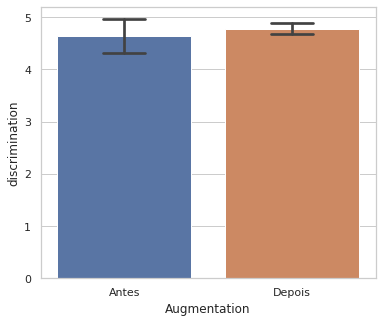

In [ ]:
plt.figure(figsize=(6,5))
plt.prism()
sns.set(style="whitegrid")
sns.barplot(x="Augmentation", y="discrimination", data=dfplot, capsize=.25, ci="sd")
plt.savefig("/content/plotA")

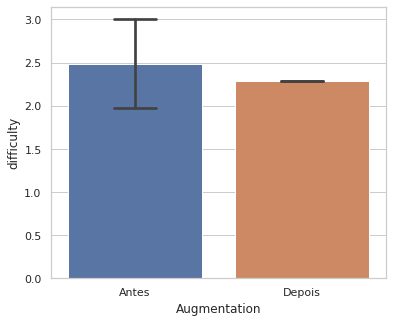

In [ ]:
plt.figure(figsize=(6,5))
plt.prism()
sns.set(style="whitegrid")
sns.barplot(x="Augmentation", y="difficulty", data=dfplot, capsize=.25, ci="sd")
plt.savefig("/content/plotB")

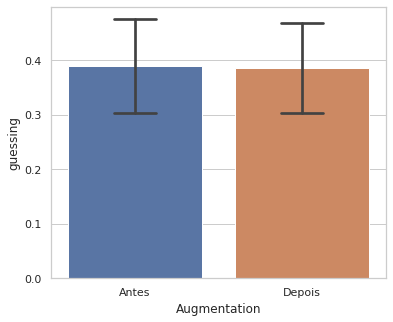

In [ ]:
plt.figure(figsize=(6,5))
plt.prism()
sns.set(style="whitegrid")
sns.barplot(x="Augmentation", y="guessing", data=dfplot, capsize=.25, ci="sd")
plt.savefig("/content/plotC")

#TRI + DBMA

In [ ]:
idx_maisdiscriminantes = np.array(dfa_ordenado['itens'][:30])
idx_maisdificeis = np.array(dfb_ordenado['itens'][:30])
idx_chutes = np.array(dfc_ordenado['itens'][:30])

coefa = np.array(dfa_ordenado['a'][:30])
coefb = np.array(dfb_ordenado['b'][:30])
coefc = np.array(dfc_ordenado['c'][:30])

In [ ]:
dfb_ordenado

,itens,a,b,c,d
11,12,1.620347,2.874250,0.133812,0.810732
90,91,1.981177,2.802393,0.004483,0.884505
19,20,1.981177,2.802393,0.004483,0.884505
96,97,1.981177,2.802393,0.004483,0.884505
185,186,1.981177,2.802393,0.004483,0.884505
...,...,...,...,...,...
115,116,1.145158,-2.572048,0.065956,0.878747
148,149,1.145158,-2.572048,0.065956,0.878747
150,151,1.145158,-2.572048,0.065956,0.878747
130,131,1.338721,-2.653560,0.069870,0.863745


In [ ]:
print(idx_maisdiscriminantes) 
print(idx_maisdificeis) 
print(idx_chutes) 


[101 147   8  22  13  11  15  58  72  28  86  67  34  35  37  68  82  40
  44  98  17  45  89  52  63  62  59  54  29  33]
[  9  97 186  12  91  55  78  20  79  49  84  90 124   3  93  56  39   1
 183  77  76  25  47  71  48   6  70 197  82  40]
[101 147 197 179 175 118 120 192 137 108  12 170  90 124 138 131 132 134
 116 151 174 148 181 149  53  94  41  57  99  50]


In [ ]:
def TRIpoints(idx_coef):
  idx = [725, 1683, 1424, 1708, 1334, 1930, 122, 1776, 1446, 1707, 415, 54, 1737, 445, 278, 885, 1579, 1780, 1063, 674, 1544, 1727, 1862, 745, 1565, 625, 349, 366, 479, 1439, 1154, 1794, 855, 630, 1413, 1427, 1281, 323, 1060, 1920, 1554, 901, 1891, 1169, 487, 1019, 1445, 1151, 452, 917, 528, 1758, 722, 1848, 539, 1403, 1101, 306, 1346, 1201, 1071, 1186, 1469, 1261, 384, 347, 652, 1716, 1000, 1495, 558, 10, 762, 667, 1487, 1481, 886, 1606, 1752, 453, 1310, 1393, 1351, 1476, 875, 1355, 56, 1950, 365, 1454, 1957, 1945, 1142, 657, 1566, 663, 668, 1893, 1237, 636, 1079, 899, 1985, 39, 1724, 533, 936, 1983, 260, 1250, 1400, 1248, 1688, 593, 483, 591, 1798, 1881, 1179, 971, 1466, 1200, 1618, 1593, 345, 397, 631, 906, 1592, 1236, 1022, 1027, 575, 847, 1615, 190, 817, 423, 1141, 1116, 687, 570, 1189, 1190, 500, 336, 371, 22, 1590, 545, 499, 140, 627, 916, 1388, 85, 1329, 523, 1373, 1150, 460, 289, 502, 135, 1754, 1651, 1024, 276, 1354, 793, 1702, 1885, 1067, 1382, 409, 717, 585, 1028, 35, 1068, 1490, 1110, 951, 372, 938, 747, 1807, 1280, 1091, 253, 1499, 1399, 1489, 1340, 442, 800, 1577, 1946, 1879, 1402]

  idx_ori = []
  for i in idx_coef:
    idx_ori.append(idx[i-1])

  print(idx_ori)
  
  itens_X_proj = np.array([[0, 0]])
  for i in idx_ori:
    itens_X_proj = np.concatenate((itens_X_proj, [pred[i]]), axis=0)  

  return itens_X_proj[1:,:] #Para excluir o primeiro elemento [0,0]

[652, 1758, 1281, 1355, 365, 1393, 479, 366, 1920, 1169, 487, 886, 1727, 1893, 1413, 1481, 306, 278, 1469, 1186, 1716, 1776, 1346, 630, 415, 1848, 1565, 558, 1737, 1445]
[54, 1957, 674, 668, 747, 1446, 1606, 539, 1752, 1476, 1060, 1403, 1593, 349, 1579, 1142, 452, 725, 951, 1930, 558, 1424, 1565, 10, 1151, 1737, 1445, 1190, 1879, 1110]
[1577, 409, 1079, 1983, 35, 1881, 793, 54, 1399, 817, 371, 1593, 1022, 1027, 971, 847, 423, 1382, 1590, 499, 1490, 591, 22, 1201, 1261, 1554, 1891, 1780, 1101, 1063]


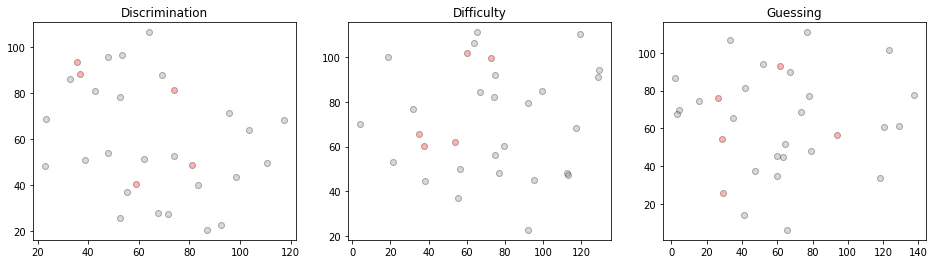

In [ ]:
itens_X_proj_a = TRIpoints(idx_maisdiscriminantes)
itens_X_proj_b = TRIpoints(idx_maisdificeis)
itens_X_proj_c = TRIpoints(idx_chutes)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.set_title('Discrimination')
ax1.scatter(itens_X_proj_a[5:, 0]* 145 + 0.5, itens_X_proj_a[5:, 1]* 145 + 0.5, c= 'gray', edgecolors='black',alpha= 0.3)
ax1.scatter(itens_X_proj_a[:5, 0]* 145 + 0.5, itens_X_proj_a[:5, 1]* 145 + 0.5, c= 'red', edgecolors='black',alpha= 0.3)
ax2.set_title('Difficulty')
ax2.scatter(itens_X_proj_b[5:, 0]* 145 + 0.5, itens_X_proj_b[5:, 1]* 145 + 0.5, c= 'gray', edgecolors='black', alpha= 0.3)
ax2.scatter(itens_X_proj_b[:5, 0]* 145 + 0.5, itens_X_proj_b[:5, 1]* 145 + 0.5, c= 'red', edgecolors='black', alpha= 0.3)
ax3.set_title('Guessing')
ax3.scatter(itens_X_proj_c[5:, 0]* 145 + 0.5, itens_X_proj_c[5:, 1]* 145 + 0.5, c='gray', edgecolors='black', alpha= 0.3)
ax3.scatter(itens_X_proj_c[:5, 0]* 145 + 0.5, itens_X_proj_c[:5, 1]* 145 + 0.5, c='red', edgecolors='black', alpha= 0.3)

plt.savefig("/content/experimento3.png")

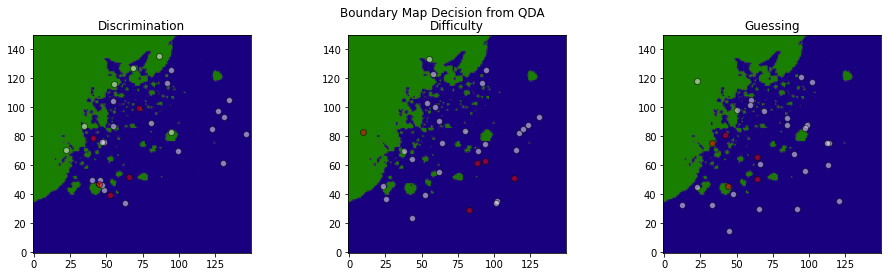

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Boundary Map Decision from "+ str(names[5])) 

ax1.imshow(hsv_to_rgb(dbmap.hsv_map), origin='lower')
ax1.set_title('Discrimination')
ax1.scatter(itens_X_proj_a[5:, 0] * 145 + 0.5, itens_X_proj_a[5:, 1] * 145 + 0.5,  c= 'white', edgecolors='black', alpha = 0.5)
ax1.scatter(itens_X_proj_a[:5, 0] * 145 + 0.5, itens_X_proj_a[:5, 1] * 145 + 0.5,  c= 'red', edgecolors='black', alpha = 0.5)

ax2.imshow(hsv_to_rgb(dbmap.hsv_map), origin='lower')
ax2.set_title('Difficulty')
ax2.scatter(itens_X_proj_b[5:, 0] * 145 + 0.5 , itens_X_proj_b[5:, 1]* 145 + 0.5 , c= 'white', edgecolors='black', alpha = 0.5)
ax2.scatter(itens_X_proj_b[:5, 0] * 145 + 0.5 , itens_X_proj_b[:5, 1]* 145 + 0.5 , c= 'red', edgecolors='black', alpha = 0.5)

ax3.imshow(hsv_to_rgb(dbmap.hsv_map), origin='lower')
ax3.set_title('Guessing')
ax3.scatter(itens_X_proj_c[5:, 0] * 144 , itens_X_proj_c[5:, 1] * 144 , c= 'white', edgecolors='black', alpha = 0.5)
ax3.scatter(itens_X_proj_c[:5, 0] * 144 , itens_X_proj_c[:5, 1] * 144 , c= 'red', edgecolors='black', alpha = 0.5)

#Na escala gray, os brancos sao os de maior coeficiente, e os pretos de menor.
plt.savefig("/content/drive/Shareddrives/TRI/DBmaps/antes/"+ str(names[5]) + "_diffpoints.png")
#plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Vizinhos mais próximos


In [ ]:
pontodificil = 11 #66, 11, 196
pontodificil = idx[pontodificil]
pontodificil

54

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [ ]:
k = 10 #número de vizinhos próximos
nbrs = NearestNeighbors(n_neighbors = k, algorithm ='ball_tree').fit(pred)
distances, indices = nbrs.kneighbors(pred)
indices_neigh= indices[pontodificil]


In [ ]:
classes_neigh= []
for i in indices_neigh:
  classes_neigh.append(pred1[i]) 
classes_neigh

[4, 2, 4, 2, 4, 2, 2, 4, 4, 2]

In [ ]:
cont = 0
dist = distances[pontodificil][0]
dist_classediferente = 0
for i in range(1, k):
  if (classes_neigh[0] == classes_neigh[i]): 
    cont = cont + 1
    dist = dist + distances[pontodificil][i]
  else:
    dist_classediferente = dist_classediferente + distances[pontodificil][i]

percentual = cont * 100/(k-1)
dist = dist/ cont
dist_classediferente = dist_classediferente / (k - 1 - cont)

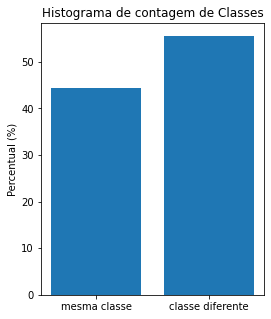

In [ ]:
fig = plt.figure(figsize=(4, 5))
label = ['mesma classe', 'classe diferente']
contagem = [percentual, (100-percentual)]
#contagem = [60, 40]
plt.bar(label, contagem)
plt.title("Histograma de contagem de Classes")
plt.ylabel("Percentual (%)")
plt.savefig("/content/contagem.png")

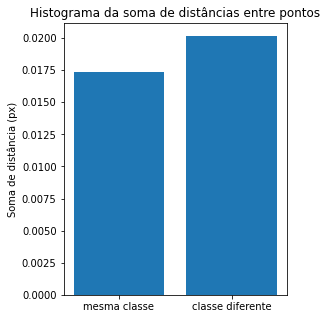

In [ ]:
fig = plt.figure(figsize=(4, 5))
label = ['mesma classe', 'classe diferente']
distancia = [dist, dist_classediferente]
plt.bar(label, distancia)
plt.title("Histograma da soma de distâncias entre pontos")
plt.ylabel("Soma de distância (px)")
plt.savefig("/content/distancia.png")

# Com Aumentação a partir da:



# DISCRIMINAÇÃO


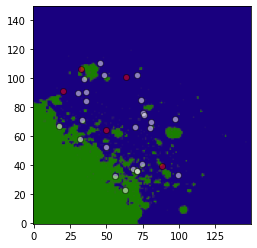

In [ ]:
 
plt.imshow(hsv_to_rgb(dbmap.hsv_map), origin='lower')
plt.scatter(itens_X_proj_a[5:, 0] * 145 + 0.5 , itens_X_proj_a[5:, 1]* 145 + 0.5 , c= 'white', edgecolors='black', alpha = 0.5)
plt.scatter(itens_X_proj_a[:5, 0] * 145 + 0.5 , itens_X_proj_a[:5, 1]* 145 + 0.5 , c= 'red', edgecolors='black', alpha = 0.5)

plt.savefig("/content/drive/Shareddrives/TRI/DBmaps/depois/a/"+ str(names[5])+".png")

# DIFICULDADE

FileNotFoundError: ignored

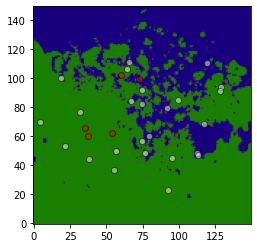

In [ ]:
plt.imshow(hsv_to_rgb(dbmap.hsv_map), origin='lower')
plt.scatter(itens_X_proj_b[5:, 0] * 145 + 0.5 , itens_X_proj_b[5:, 1]* 145 + 0.5 , c= 'white', edgecolors='black', alpha = 0.5)
plt.scatter(itens_X_proj_b[:5, 0] * 145 + 0.5 , itens_X_proj_b[:5, 1]* 145 + 0.5 , c= 'red', edgecolors='black', alpha = 0.5)
plt.savefig("/content/drive/Shareddrives/TRI/DBmaps/depois/b/"+ str(names[5])+".png")

# CHUTE

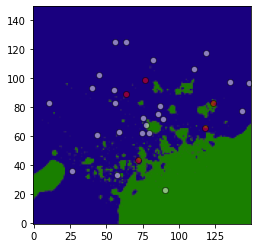

In [ ]:
plt.imshow(hsv_to_rgb(dbmap.hsv_map), origin='lower')
plt.scatter(itens_X_proj_c[5:, 0] * 145 + 0.5 , itens_X_proj_c[5:, 1]* 145 + 0.5 , c= 'white', edgecolors='black', alpha = 0.5)
plt.scatter(itens_X_proj_c[:5, 0] * 145 + 0.5 , itens_X_proj_c[:5, 1]* 145 + 0.5 , c= 'red', edgecolors='black', alpha = 0.5)

plt.savefig("/content/drive/Shareddrives/TRI/DBmaps/depois/c/"+ str(names[5])+".png")